In [1]:
#load modules
print('loading modules...')
import numpy as np
import basic
import pickle
import curvedsky
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

##########################################################################

import os,sys
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp

sys.path.append("/root/Testarea/prototype/BACKTOFUTURE")

from noise_making import *
from utils_mine import *
from phi_noise_making import *
from generate_map import *
from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))    
sys.path.insert(0,camb_path)



import camb
from camb import model, initialpower ,correlations

from scipy.special import factorial

import pymaster as nm


sys.path.append("/root/Testarea/prototype/Foreground")
from utils_mine import *


import pymaster as nmt

loading modules...
loading modules...
loading modules...
loading modules...


In [2]:
def get_pseudo_cl(nside,mask_input,flag,bin,lmax=None,apo=False,f0=None,f2=None,is_Dell=True):
    """
        nside:
        mask_input:最好是nside的mask,否则apodization很慢;或者输入apodization后的mask
        flag: '00' '02' '22',依次为spin-0 x spin-0,spin-0 x spin-2,spin-2 x spin-2
        bin: 每个bin的多极项数目
        lmax: 用于计算pseudo-Cl的lmax,默认为-1,即使用3*nside-1
        apo: 是否输入了apodization后的mask
        f0: spin-0 field
        f2: spin-2 field
    """
        
    import numpy as np
    import healpy as hp
    import matplotlib.pyplot as plt

    # Import the NaMaster python wrapper
    import pymaster as nmt

    if lmax is None:
        lmax = 3*nside - 1
    if apo == True:
        mask = mask_input
    else:
        mask = nmt.mask_apodization(mask_input,  1., apotype="Smooth")           # apodization中的参数可以调整，这里为 1 degree
    #hp.orthview(mask, half_sky=True, rot=[180, 30, 0],cmap='YlGnBu_r',title='Apodized mask')
    print('mask apodization done')
    
    # Read healpix maps and initialize a spin-0 and spin-2 field
    
    # Initialize binning scheme with 'bin' ells per bandpower
    #b = nmt.NmtBin.from_nside_linear(nside, bin, is_Dell=is_Dell)
    b = nmt.NmtBin.from_lmax_linear(lmax, bin, is_Dell=is_Dell)
    ell_arr = b.get_effective_ells()
    if isinstance(f0, (list, tuple)):
        f0_1 = [f0[0]]
        f0_2 = [f0[1]]
    else:
        f0_1 = [f0]
        f0_2 = [f0]
    print(len(f0_1),len(f0_2))
    # Compute MASTER estimator
    # spin-0 x spin-0
    if flag == '00':
        f_01 = nmt.NmtField(mask, f0_1,)
        f_02 = nmt.NmtField(mask, f0_2,)

        print('pseudo cl calculating ')
        cl_00 = nmt.compute_full_master(f_01, f_02, b)    #TT为 cl_00[0]
        return ell_arr,cl_00

    # spin-0 x spin-2
    if flag == '02':
        f_0 = nmt.NmtField(mask, f0_1,)
        f_2 = nmt.NmtField(mask, f2, spin=2, purify_e=True, purify_b=True, n_iter_mask_purify=3, )
        assert f_0 is not None
        assert f_2 is not None
        print('pseudo cl calculating ')
        cl_02 = nmt.compute_full_master(f_0, f_2, b)
        return ell_arr,cl_02
    
    # spin-2 x spin-2
    if flag == '22':
        f_2 = nmt.NmtField(mask, f2, spin=2, purify_e=True, purify_b=True, n_iter_mask_purify=3, )
        assert f_2 is not None
        print('pseudo cl calculating ')
        cl_22 = nmt.compute_full_master(f_2, f_2, b)      #EE,BB 分别为 cl_22[0]，cl_22[3]
        return ell_arr,cl_22
    
def add_beam(fwhm_ac,nside,maps,lmax=None,pixwin=False):
    if lmax == None:
        lmax =3*nside-1
    transf = bl(fwhm_ac, nside=nside, lmax=lmax, pixwin=pixwin)
    tlm_len = hp.map2alm(maps[0], lmax=lmax)
    elm_len, blm_len = hp.map2alm_spin([maps[1], maps[2]], 2, lmax=lmax)
    Tlen = hp.alm2map(hp.almxfl(tlm_len, transf, inplace=True), nside, verbose=False)
    Qlen, Ulen = hp.alm2map_spin([hp.almxfl(elm_len, transf), hp.almxfl(blm_len, transf)], nside, 2, lmax)
    return Tlen,Qlen,Ulen

def map_cut(nside,maps,lmax):
    tlm_len = hp.map2alm(maps[0], lmax=lmax)
    elm_len, blm_len = hp.map2alm_spin([maps[1], maps[2]], 2, lmax=lmax)
    Tlen = hp.alm2map(tlm_len,nside, verbose=False)
    Qlen, Ulen = hp.alm2map_spin([elm_len, blm_len,], nside, 2, lmax)
    return Tlen,Qlen,Ulen


def decon_map(fwhm_ac,nside,maps,lmax,pixwin=False):
    """
    deconvolve map with beam
    """
    if lmax == None:
        lmax =3*nside-1
    transf = 1/bl(fwhm_ac, nside=nside, lmax=lmax, pixwin=pixwin)
    tlm_len = hp.map2alm(maps[0], lmax=lmax)
    elm_len, blm_len = hp.map2alm_spin([maps[1], maps[2]], 2, lmax=lmax)
    Tlen = hp.alm2map(hp.almxfl(tlm_len, transf, inplace=True), nside, verbose=False)
    Qlen, Ulen = hp.alm2map_spin([hp.almxfl(elm_len, transf), hp.almxfl(blm_len, transf)], nside, 2, lmax)
    return Tlen,Qlen,Ulen

def qu2eb_map(nside,lmax,Qmap,Umap):
    """convert Q/U map to E/B map, only correct for full sky, but leads negligible corruption to partial sky E mode"""
    elm,blm = hp.map2alm_spin([Qmap,Umap],2)
    Emap = hp.alm2map(elm,nside,)
    Bmap = hp.alm2map(blm,nside,)
    return Emap,Bmap


-----------------------------------

In [3]:
#Define a function to get the theory Cl
print('setting parameters...')
nside = 1024
lmax = 3*nside-1
lmax_len = 3*nside-1 # desired lmax of the lensed field.
dlmax = 3*nside-1   # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
epsilon = 1e-6  # target accuracy of the output maps (execution time has a fairly weak dependence on this)
lmax_unl, mmax_unl = lmax_len + dlmax  , lmax_len + dlmax 
if nside == 2048 or nside == 4096:
    lmax_unl, mmax_unl = 10000  , 10000
Tcmb = 2.7255e6

#Define a function to get the theory Cl
def get_cl(r):
    #temporary used for generating the input Cls
    #运行Camb，给出理论计算结果
    #print('running CAMB...')
    #Set up a new set of parameters for CAMB
    #对象 pars 用于存储和设置 CAMB 的参数
    pars = camb.CAMBparams()
    #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency

    #parameters from planck FFP10_wdipole_params.ini
    #通过调用 set_cosmology 方法设置宇宙学参数。其中： H0为Hubble 常数、ombh2为重子物质密度参数、omch2为冷暗物质密度参数、mnu为中微子的质量、omk为曲率参数 、tau为再电离光深度 
    pars = camb.set_params(H0=67.01904, ombh2=0.02216571, omch2=0.1202944, mnu=0.0006451439, omk=0, tau=0.06018107, YHe=0.2453006, num_nu_massless=2.03066666667, nu_mass_eigenstates = 1,\
                        num_nu_massive=1, share_delta_neff=False, nu_mass_degeneracies = [1.01533333333],nu_mass_fractions = [1], Alens = 1.00000000000000,\
                        w=-1.0, wa=0, nnu=3.046, nt=-r/8.0, nrun=0, pivot_scalar=0.05, pivot_tensor=0.05, TCMB = 2.7255 )

    # 启用张量模式
    pars.WantTensors = True

    #使用 set_params 方法设置功率谱的初始参数，包括幂律指数 ns、标量扰动的振幅 As 和张量-标量比例 r。
    pars.InitPower.set_params(As=2.119631e-09, ns=0.9636852, r=r)

    #使用 set_for_lmax 方法设置计算的最大多极限 lmax 和透镜势计算的精度 lens_potential_accuracy。
    pars.set_for_lmax(lmax_unl, lens_potential_accuracy=8)

    #calculate results for these parameters
    results = camb.get_results(pars)

    ##############################################################################
    #生成时无量纲，对CMB auto spectrum 要乘Tcmb**2, 对lensing potential auto spectrum 保持无量纲, 对CMB-potential cross spectrum 乘Tcmb
    cl_ppte=results.get_lens_potential_cls(lmax=None, CMB_unit='muK', raw_cl=True)   #numpy array CL[0:lmax+1,0:3], where 0..2 indexes PP, PT, PE.(T,E均unlensed)
    clpp=cl_ppte[:,0]

    unlensed_total = results.get_unlensed_total_cls(raw_cl=False) * Tcmb**2 # unlensed CMB power spectra, including tensors

    dl_ppte=results.get_lens_potential_cls(lmax=None, CMB_unit='muK', raw_cl=False)   #numpy array CL[0:lmax+1,0:3], where 0..2 indexes PP, PT, PE.(T,E均unlensed)
    dlpp=dl_ppte[:,0]
    lensed_cl = results.get_lensed_cls_with_spectrum(dlpp, lmax=None, CMB_unit=None, raw_cl=False) * Tcmb**2
    return unlensed_total,lensed_cl

setting parameters...


In [4]:
#Prepare for the data and theory Cl
dl_tens_1, dl_lens_1= get_cl(1)
dl_tens_1_continue = dl_tens_1[:1000,2]    ############ tensor

l,dl_tens_1 = get_binned(nside,20,dl_tens_1_continue,999)
l,dl_lens_1 = get_binned(nside,20,dl_lens_1[:1000,2] ,999)

dl_tens_0, dl_lens_0= get_cl(0)
#dl_lens = dl_lens_0[:1000,2]     ############# lensing
l,dl_lens_0 = get_binned(nside,20,dl_lens_0[:1000,2] ,999)

#dl_lens = np.loadtxt('./data/lensedb.txt')


In [5]:
'''
data_vec = np.array([data_obs[(27,27)],data_obs[(27,39)],data_obs[(27,93)],data_obs[(27,145)],data_obs[(27,225)],data_obs[(27,280)],data_cross[27],
            data_obs[(39,39)],data_obs[(39,93)],data_obs[(39,145)],data_obs[(39,225)],data_obs[(39,280)],data_cross[39],
            data_obs[(93,93)],data_obs[(93,145)],data_obs[(93,225)],data_obs[(93,280)],data_cross[93],
            data_obs[(145,145)],data_obs[(145,225)],data_obs[(145,280)],data_cross[145],
            data_obs[(225,225)],data_obs[(225,280)],data_cross[225],
            data_obs[(280,280)],data_cross[280],
            data_LT])
'''

'\ndata_vec = np.array([data_obs[(27,27)],data_obs[(27,39)],data_obs[(27,93)],data_obs[(27,145)],data_obs[(27,225)],data_obs[(27,280)],data_cross[27],\n            data_obs[(39,39)],data_obs[(39,93)],data_obs[(39,145)],data_obs[(39,225)],data_obs[(39,280)],data_cross[39],\n            data_obs[(93,93)],data_obs[(93,145)],data_obs[(93,225)],data_obs[(93,280)],data_cross[93],\n            data_obs[(145,145)],data_obs[(145,225)],data_obs[(145,280)],data_cross[145],\n            data_obs[(225,225)],data_obs[(225,280)],data_cross[225],\n            data_obs[(280,280)],data_cross[280],\n            data_LT])\n'

In [5]:
data_vec = np.loadtxt('./data_vec_fit_average.txt') #[28,49]
COV_sim = np.load('./COV_matrix.npy')           #[49,28,28]

In [6]:
vec = {(27,27):data_vec[0], (27,39):data_vec[1], (27,93):data_vec[2], (27,145):data_vec[3], (27,225):data_vec[4], (27,280):data_vec[5], (27,999):data_vec[6],
            (39,39):data_vec[7], (39,93):data_vec[8], (39,145):data_vec[9], (39,225):data_vec[10], (39,280):data_vec[11], (39,999):data_vec[12],
            (93,93):data_vec[13], (93,145):data_vec[14], (93,225):data_vec[15], (93,280):data_vec[16], (93,999):data_vec[17],
            (145,145):data_vec[18], (145,225):data_vec[19], (145,280):data_vec[20], (145,999):data_vec[21],
            (225,225):data_vec[22], (225,280):data_vec[23], (225,999):data_vec[24],
            (280,280):data_vec[25], (280,999):data_vec[26],
            (999,999):data_vec[27]}     #notice: Here "999" represents the LT for short

In [7]:
COV_th = np.zeros((49, 28, 28))
for l in range(49):
    lbin = 10*(2*l+1)
    for i, key1 in enumerate(vec.keys()):
        for j, key2 in enumerate(vec.keys()):
            key3 = (key1[0],key2[0]) if key1[0] <= key2[0] else (key2[0],key1[0])
            key4 = (key1[1],key2[1]) if key1[1] <= key2[1] else (key2[1],key1[1])
            key5 = (key1[0],key2[1]) if key1[0] <= key2[1] else (key2[1],key1[0])
            key6 = (key1[1],key2[0]) if key1[1] <= key2[0] else (key2[0],key1[1])
            #print(key1,key2,key3,key4,key5,key6)
            COV_th[l,i,j] = 1/(2*lbin+1) * (vec[key3][l] * vec[key4][l] + vec[key5][l] * vec[key6][l])

In [8]:
dl_lens = np.loadtxt('./LT_LT_mean.txt')[5]
with open('./dlbb_noise_average.pkl', 'rb') as f:
    dl_noise = pickle.load(f)

with open('./dlbb_FG_average.pkl', 'rb') as f:
    dl_FGs = pickle.load(f)

In [9]:
with open('/root/Testarea/prototype/Foreground/post_cal_temp_rec_new2/dlbb_noise_average.pkl', 'rb') as f:
    dl_noise1 = pickle.load(f)

with open('./dlbb_noise_average.pkl', 'rb') as f:
    dl_noise2 = pickle.load(f)

In [10]:
k  = (39,39)
plt.loglog(ell_eff, dl_noise1[k][0], ".",label = f'noise 1')
plt.loglog(ell_eff, dl_noise2[k][0], ".",label = f'noise 2')

plt.ylim(1e-5,1e3)

NameError: name 'ell_eff' is not defined

In [10]:
"""
#理论计算sigma(r)
fsky = 0.05563032882251974
lbin=50
sigma_r_th = (np.sum((2*l+1)/2*fsky*lbin*(dl_tens_1/Cl_average[0])**2))**-0.5
print("Theoratical sigma(r) without delensing:",sigma_r_th)
sigma_r_th_de = (np.sum((2*l+1)/2*fsky*lbin*(dl_tens_1/(Cl_average[4] + dl_noise_temp))**2))**-0.5
print("Theoratical sigma(r) with delensing:",sigma_r_th_de)
"""

'\n#理论计算sigma(r)\nfsky = 0.05563032882251974\nlbin=50\nsigma_r_th = (np.sum((2*l+1)/2*fsky*lbin*(dl_tens_1/Cl_average[0])**2))**-0.5\nprint("Theoratical sigma(r) without delensing:",sigma_r_th)\nsigma_r_th_de = (np.sum((2*l+1)/2*fsky*lbin*(dl_tens_1/(Cl_average[4] + dl_noise_temp))**2))**-0.5\nprint("Theoratical sigma(r) with delensing:",sigma_r_th_de)\n'

In [9]:
#NOTICE: Here we use uK_CMB unit.
class fg_model:
    def __init__(self):
        None
    def unit_convert(self,nu):  #NOTICE: Both of our CMB map and fg map are in KCMB unit, therefore we don't need this unit conversion, and work just in KCMB unit.
        h = 6.62607015e-34
        k = 1.380649e-23
        Tcmb = 2.7255
        x = h*nu/k/Tcmb
        f_CMB2RJ = np.exp(x)*(x/(np.exp(x)-1))**2   
        return f_CMB2RJ
    
    def fg_spectra(self, nu, beta_s, beta_d, Td = 19.6, nu0_s=23*1e9, nu0_d=353*1e9):  #NOTICE :Since our fg map are in KCMB unit, this fg_spectra should also be converted to KCMB unit.
        """
        A factor concerning frequency dependence of the fg spatial spectra.
        """
        h = 6.62607015e-34
        k = 1.380649e-23
        Tcmb = 2.7255
        Td = 19.6   #in K
        f_s = (nu/nu0_s) ** beta_s     / (self.unit_convert(nu)/self.unit_convert(nu0_s))                           #If you use uKCMB unit, you should add this unit conversion.
        f_d = (nu/nu0_d) ** (beta_d + 1) * (np.exp(h*nu0_d/k/Td)-1) / (np.exp(h*nu/k/Td)-1)    / (self.unit_convert(nu)/self.unit_convert(nu0_d))
        return f_s, f_d
    
    def decorrelation(self, delta_s,delta_d,  nu1, nu2, rat, nu0_s=[23*1e9, 33*1e9], nu0_d=[217*1e9, 353*1e9,]):
        # Calculate factor by which foreground (dust or sync) power is decreased
        # for a cross-spectrum between two different frequencies.
        # 暂时不用这个函数，若使用需要根据nuo_d和nuo_s的D_l确定delta_s和delta_d的值，参考BICEP2: arcxiv:1810.05216的附录H和G。
        if nu1 == nu2:
            decorr_s = 1
            decorr_d = 1
        
        decorr_ss = delta_s**( (np.log(nu1 / nu2) ** 2) / (np.log(nu0_s[0] / nu0_s[1]) ** 2) )
        decorr_dd = delta_d**( (np.log(nu1 / nu2) ** 2) / (np.log(nu0_d[0] / nu0_d[1]) ** 2) )

        return decorr_ss, decorr_dd
        
    def Dl_fg_nu(self, lmax, bin, A, alpha, l0 = 80, if_bin = True):  # We only consdier BB power spectrum here. 
        """
        Deprecated!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        """
        l = np.arange(10000)
        Dl = A * (l/l0) ** alpha                            #This is the power law Dl of the fg in unit of uK_RJ^2.
        if if_bin == 1:
            _, output = get_binned(nside,bin,Dl[:lmax+1],lmax)
        else:
            output = Dl
        return output
    
    def Dl_fg_auto_nu(self, nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, l0 = 80, if_bin = True):  #Retuen Dl_dd, Dl_ss for single frequency
        l = np.arange(10000)
        Dl_d = A_d * (l/l0) ** alpha_d
        Dl_s = A_s * (l/l0) ** alpha_s
        f_s1,f_d1 = self.fg_spectra(nu1, beta_s, beta_d)
        f_s2,f_d2 = self.fg_spectra(nu2, beta_s, beta_d)
        Dl_dd = f_d1 *f_d2 * Dl_d
        Dl_ss = f_s1 *f_s2 * Dl_s
        if if_bin == 1:
            lbin, output1 = get_binned(nside,bin,Dl_dd[:lmax+1],lmax)
            lbin, output2 = get_binned(nside,bin,Dl_ss[:lmax+1],lmax)
        else:
            lbin, output1 = l,Dl_dd
            lbin, output2 = l,Dl_ss
        return lbin,output1,output2

    def Dl_fg_cross_nu(self, nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s1, beta_s2, beta_d1, beta_d2, eps_ds, l0 = 80, if_bin = True):  #Return Dl_ds for two (or one) frequency
        l = np.arange(10000)
        Dl_d = A_d * (l/l0) ** alpha_d
        Dl_s = A_s * (l/l0) ** alpha_s
        f_s1,f_d1 = self.fg_spectra(nu1, beta_s1, beta_d1)
        f_s2,f_d2 = self.fg_spectra(nu2, beta_s2, beta_d2)
        Dl_cross = eps_ds *(f_d1*f_s2*np.sqrt(Dl_d * Dl_s) + f_d2*f_s1*np.sqrt(Dl_d * Dl_s)) 
        if if_bin == 1:
            lbin, output = get_binned(nside,bin,Dl_cross[:lmax+1],lmax)
        else:
            lbin,output = l,Dl_cross
        return  lbin,output
    

def get_fg_cross(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s1, beta_s2, beta_d1, beta_d2, eps_ds, l0 = 80, if_bin = False):      #Eq(2.9)
    fg = fg_model()
    lbin, Dl_ds = fg.Dl_fg_cross_nu(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s1, beta_s2, beta_d1, beta_d2, eps_ds, l0 = 80, if_bin = if_bin)
    return lbin, Dl_ds


def get_fg_total(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, l0 = 80, if_bin = False):
    fg = fg_model()
    lbin, Dl_dd, Dl_ss = fg.Dl_fg_auto_nu(nu1, nu2,lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, l0 = l0, if_bin = if_bin)
    _,dl_ds = get_fg_cross(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_s, beta_d, beta_d, eps_ds, l0 = l0, if_bin = if_bin)
    return lbin, Dl_dd + Dl_ss + dl_ds


def map_rescale(nside,map,trans,lmax=None,):
    if lmax == None:
        lmax=3*nside-1
    alm = hp.map2alm(map,lmax,lmax)
    alm_rescale = hp.almxfl(alm,cli(trans))
    map_rescale = hp.alm2map(alm_rescale,nside,lmax)
    return map_rescale


########################################## 以下为整合到一个函数内的代码，等效 ####################################################
def cal_fg_power(nu1,nu2,lmax,bin,A_d,A_s,alpha_s,alpha_d,beta_s,beta_d,eps_ds,if_bin = True):
    nu0_s = 23*1e9
    nu0_d = 353*1e9
    l0 = 80
    h = 6.62607015e-34
    k = 1.380649e-23
    Td = 19.6
    T_cmb = 2.7255
    l = np.arange(10000)

    def unit_convert(nu):  #NOTICE: Both of our CMB map and fg map are in KCMB unit, therefore we don't need this unit conversion, and work just in KCMB unit.
        x = h*nu/k/Tcmb
        f_CMB2RJ = np.exp(x)*(x/(np.exp(x)-1))**2   
        return f_CMB2RJ
    
    f_com = fg.unit_convert(nu1) * fg.unit_convert(nu2)
    dl = ((nu1*nu2/nu0_s**2)**beta_s * A_s * (l/l0)**alpha_s + (nu1*nu2/nu0_d**2)**(beta_d+1) * A_d * (np.exp(h*nu0_d/k/Td)-1)**2/(np.exp(h*nu1/k/Td)-1)/(np.exp(h*nu2/k/Td)-1) * (l/l0)**alpha_d + eps_ds * ( (nu1/nu0_s)**(beta_s) * (nu2/nu0_d)**beta_d *(np.exp(h*nu0_d/k/Td)-1)/(np.exp(h*nu2/k/Td)-1)  + (nu2/nu0_s)**(beta_s) * (nu1/nu0_d)**(beta_d +1)*(np.exp(h*nu0_d/k/Td)-1)/(np.exp(h*nu1/k/Td)-1) ) * np.sqrt( A_s * (l/l0)**alpha_s * A_d * (l/l0)**alpha_d ))
    dl /= f_com
    output = dl
    if if_bin == 1:
        _,dl_bin = get_binned(nside,bin,dl[:lmax+1],lmax)
        output = dl_bin
    return output

def cal_fg_quick(nus,lmax,bin,A_d,A_s,alpha_s,alpha_d,beta_s,beta_d,eps_ds,if_bin = True):
    dl_FG = {}
    for i,nu in nus.items():
        for j,nu in nus.items():
            if i > j :
                continue
            key = (i,j)
            dl_FG[key] = cal_fg_power(nus[i],nus[j],lmax,bin,A_d,A_s,alpha_s,alpha_d,beta_s,beta_d,eps_ds,if_bin = if_bin)
    return dl_FG

In [10]:
fg = fg_model()

def get_fg_cross(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s1, beta_s2, beta_d1, beta_d2, eps_ds, l0 = 80, if_bin = False):      #Eq(2.9)
    fg = fg_model()
    lbin, Dl_ds = fg.Dl_fg_cross_nu(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s1, beta_s2, beta_d1, beta_d2, eps_ds, l0 = 80, if_bin = if_bin)
    return lbin, Dl_ds

def get_fg_total(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, l0 = 80, if_bin = False):
    fg = fg_model()
    lbin, Dl_dd, Dl_ss = fg.Dl_fg_auto_nu(nu1, nu2,lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, l0 = l0, if_bin = if_bin)
    _,dl_ds = get_fg_cross(nu1, nu2, lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_s, beta_d, beta_d, eps_ds, l0 = l0, if_bin = if_bin)
    return lbin, Dl_dd + Dl_ss + dl_ds

nus = {27: 27 * 1e9, 39: 39 * 1e9, 93: 93 * 1e9, 145: 145 * 1e9, 225: 225 * 1e9, 280: 280 * 1e9}

def get_FG(nus,lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, if_bin = True):
    dl_FG = {}
    for i,nu in nus.items():
        for j,nu in nus.items():
            if i > j :
                continue
            key = (i,j)
            _,dl_FG[key] = get_fg_total(nus[i], nus[j], lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, if_bin = if_bin)
    return dl_FG

def get_ds_bias(nus,lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, if_bin = True):
    dl_ds_bias = {}
    for i,nu in nus.items():
        for j,nu in nus.items():
            if i > j :
                continue
            key = (i,j)
            _,dl_ds_bias[key] = get_fg_cross(nus[i], nus[j], lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_s, beta_d, beta_d, 1, if_bin = if_bin)
    return dl_ds_bias

In [11]:

A_d0 = 14.30 
alpha_d0 = -0.65
beta_d0 = 1.48

A_s0 = 2.40 
alpha_s0 = -0.80
beta_s0 = -3.10

eps_ds0 = 0

dl_FG_th = get_FG(nus, 1000, 20, A_d0, A_s0, alpha_s0, alpha_d0, beta_s0, beta_d0, eps_ds0, if_bin = True)
dl_cross_de_bias = get_ds_bias(nus, 1000, 20, A_d0, A_s0, alpha_s0, alpha_d0, beta_s0, beta_d0, if_bin = True)

/tmp/ipykernel_17238/978265064.py:52: RuntimeWarning: divide by zero encountered in power
  Dl_d = A_d * (l/l0) ** alpha_d
/tmp/ipykernel_17238/978265064.py:53: RuntimeWarning: divide by zero encountered in power
  Dl_s = A_s * (l/l0) ** alpha_s
/tmp/ipykernel_17238/978265064.py:68: RuntimeWarning: divide by zero encountered in power
  Dl_d = A_d * (l/l0) ** alpha_d
/tmp/ipykernel_17238/978265064.py:69: RuntimeWarning: divide by zero encountered in power
  Dl_s = A_s * (l/l0) ** alpha_s
/tmp/ipykernel_17238/978265064.py:72: RuntimeWarning: invalid value encountered in multiply
  Dl_cross = eps_ds *(f_d1*f_s2*np.sqrt(Dl_d * Dl_s) + f_d2*f_s1*np.sqrt(Dl_d * Dl_s))


In [12]:
dl_FG_th[(27,27)]

array([5.6751674 , 1.93975815, 1.2882435 , 0.98643764, 0.80830866,
       0.68942477, 0.60385287, 0.53900639, 0.48799341, 0.44670522,
       0.4125318 , 0.38373132, 0.35909447, 0.33775407, 0.31907116,
       0.30256406, 0.28786243, 0.27467659, 0.26277652, 0.25197717,
       0.24212787, 0.23310464, 0.22480447, 0.21714108, 0.21004155,
       0.20344387, 0.19729495, 0.19154901, 0.18616642, 0.18111264,
       0.17635746, 0.17187429, 0.16763967, 0.16363282, 0.15983521,
       0.15623034, 0.1528034 , 0.1495411 , 0.14643145, 0.14346361,
       0.14062779, 0.13791505, 0.13531729, 0.13282711, 0.13043772,
       0.12814292, 0.125937  , 0.12381474, 0.12177129])

(-0.01, 0.02)

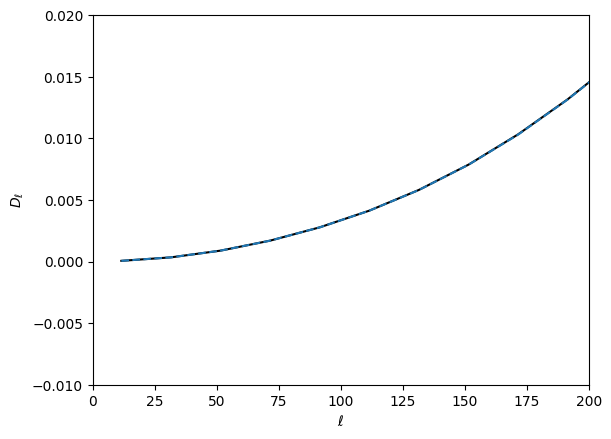

In [13]:
#Check obs_LT and LT_LT
ell_eff = [11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5, 191.5, 211.5, 231.5,
 251.5, 271.5, 291.5, 311.5, 331.5, 351.5, 371.5, 391.5, 411.5, 431.5, 451.5, 471.5,
 491.5, 511.5, 531.5, 551.5, 571.5, 591.5, 611.5, 631.5, 651.5, 671.5, 691.5, 711.5,
 731.5, 751.5, 771.5, 791.5, 811.5, 831.5, 851.5, 871.5, 891.5, 911.5, 931.5, 951.5,
 971.5,]

k=27

plt.plot(ell_eff, dl_lens, "k",label = f'lensed B')
plt.plot(ell_eff, data_vec[k], "--",label = f'LT_27')


plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$')
plt.xlim(0,200)
plt.ylim(-0.01,0.02)

In [16]:
data_vec[0]

array([ 2.79943922e+00,  1.76817990e+00,  1.22383571e+00,  1.07938036e+00,
        1.16540941e+00,  1.67026780e+00,  3.17609386e+00,  7.65008709e+00,
        2.04433140e+01,  7.44834692e+01,  6.26099785e+01, -4.65411956e+00,
        1.77378420e-01, -7.83921020e-02, -3.94636454e-02, -3.17446974e-02,
       -2.67367866e-02, -2.32322872e-02, -2.08414967e-02, -1.89491877e-02,
       -1.75413225e-02, -1.62376284e-02, -1.53152171e-02, -1.43946698e-02,
       -1.36604844e-02, -1.29781831e-02, -1.23448210e-02, -1.18886399e-02,
       -1.13157383e-02, -1.09432793e-02, -1.05154649e-02, -1.01411059e-02,
       -9.83229645e-03, -9.48262761e-03, -9.23070858e-03, -8.93093694e-03,
       -8.65373695e-03, -8.41788092e-03, -8.20157801e-03, -7.97461812e-03,
       -7.77922305e-03, -7.60895625e-03, -7.39800051e-03, -7.25524813e-03,
       -7.09706276e-03, -6.94287573e-03, -6.80918513e-03, -6.66625551e-03,
       -7.12130772e-03])

In [14]:
with open('./obs_obs/dlbb_obs_obs_0.pickle', 'rb') as f:
    dl_obs = pickle.load(f)

In [15]:
dl_FG_th[(27,27)]

array([5.6751674 , 1.93975815, 1.2882435 , 0.98643764, 0.80830866,
       0.68942477, 0.60385287, 0.53900639, 0.48799341, 0.44670522,
       0.4125318 , 0.38373132, 0.35909447, 0.33775407, 0.31907116,
       0.30256406, 0.28786243, 0.27467659, 0.26277652, 0.25197717,
       0.24212787, 0.23310464, 0.22480447, 0.21714108, 0.21004155,
       0.20344387, 0.19729495, 0.19154901, 0.18616642, 0.18111264,
       0.17635746, 0.17187429, 0.16763967, 0.16363282, 0.15983521,
       0.15623034, 0.1528034 , 0.1495411 , 0.14643145, 0.14346361,
       0.14062779, 0.13791505, 0.13531729, 0.13282711, 0.13043772,
       0.12814292, 0.125937  , 0.12381474, 0.12177129])

(1e-05, 1000.0)

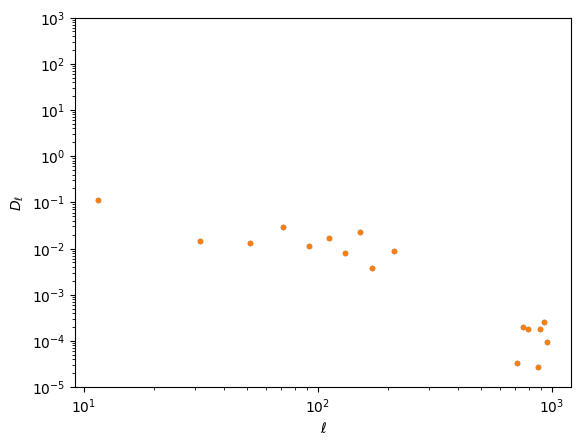

In [18]:
#Chcek obs_obs

k=5
key=(27,27)
#plt.loglog(ell_eff, dl_FGs[key][0] + dl_lens + dl_noise[key][0], "--",label = f'FG {key}')
#plt.loglog(ell_eff, dlbb_FGs2[key][0], "--",label = f'FG {key}')

plt.loglog(ell_eff, data_vec[k], ".",label = f'FG {key}')
plt.loglog(ell_eff, th_vec[k], ".",label = f'FG {key}')

#plt.loglog(ell_eff, dl_obs[key], "--",label = f'obs {key}')
"""
if key[0] != key[1]:
    plt.loglog(ell_eff, dl_FG_th[key] + dl_cross_de_bias[key] + dl_lens + dl_noise[key][0], label = f'th FG {key}')
else :
    plt.loglog(ell_eff, dl_FG_th[key] + dl_lens + dl_noise[key][0], label = f'th FG {key}')    #(39,39)比理论略大
plt.ylim(1e-0,1e2)
"""
plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$')
plt.ylim(1e-5,1e3)
#plt.legend()

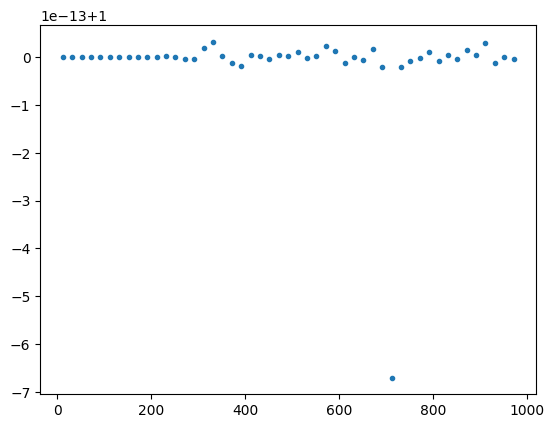

In [31]:
plt.plot(ell_eff, data_vec[k]/th_vec[k], ".",label = f'FG {key}')

In [115]:
#np.savetxt('/root/Testarea/prototype/Foreground/post_cal4/data_vec_cheat_average.txt',data_vec)

In [14]:
# Get the cheat noise power

dl_noise_cheat = {}
dl_noise_cheat[(27,27)] = data_vec[0] - dl_FG_th[(27,27)] - dl_lens 
dl_noise_cheat[(39,39)] = data_vec[7] - dl_FG_th[(39,39)] - dl_lens
dl_noise_cheat[(93,93)] = data_vec[13] - dl_FG_th[(93,93)] - dl_lens
dl_noise_cheat[(145,145)] = data_vec[18] - dl_FG_th[(145,145)] - dl_lens
dl_noise_cheat[(225,225)] = data_vec[22] - dl_FG_th[(225,225)] - dl_lens
dl_noise_cheat[(280,280)] = data_vec[25] - dl_FG_th[(280,280)] - dl_lens

dl_noise_cheat[(27,39)] = data_vec[1] - dl_FG_th[(27,39)]  - dl_lens
dl_noise_cheat[(27,93)] = data_vec[2] - dl_FG_th[(27,93)]  - dl_lens
dl_noise_cheat[(27,145)] = data_vec[3] - dl_FG_th[(27,145)]  - dl_lens
dl_noise_cheat[(27,225)] = data_vec[4] - dl_FG_th[(27,225)]  - dl_lens
dl_noise_cheat[(27,280)] = data_vec[5] - dl_FG_th[(27,280)]  - dl_lens

dl_noise_cheat[(39,93)] = data_vec[8] - dl_FG_th[(39,93)]  - dl_lens
dl_noise_cheat[(39,145)] = data_vec[9] - dl_FG_th[(39,145)]  - dl_lens
dl_noise_cheat[(39,225)] = data_vec[10] - dl_FG_th[(39,225)]  - dl_lens
dl_noise_cheat[(39,280)] = data_vec[11] - dl_FG_th[(39,280)]  - dl_lens

dl_noise_cheat[(93,145)] = data_vec[14] - dl_FG_th[(93,145)]  - dl_lens
dl_noise_cheat[(93,225)] = data_vec[15] - dl_FG_th[(93,225)]  - dl_lens
dl_noise_cheat[(93,280)] = data_vec[16] - dl_FG_th[(93,280)]  - dl_lens

dl_noise_cheat[(145,225)] = data_vec[19] - dl_FG_th[(145,225)]  - dl_lens
dl_noise_cheat[(145,280)] = data_vec[20] - dl_FG_th[(145,280)]  - dl_lens

dl_noise_cheat[(225,280)] = data_vec[23] - dl_FG_th[(225,280)]  - dl_lens


In [15]:
with open('dlbb_noise_cheat.pkl', 'wb') as f:
    pickle.dump(dl_noise_cheat, f)

In [16]:
def get_th_vec(r, AL, noise, nus, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, dl_bias=None, lmin=0, lmax=100):
    dl_tens_r = r*dl_tens_1    ############ tensor

    if dl_bias is None:
        dl_bias = 0*dl_tens_r

    dl_FG_th = get_FG(nus, 1000, 20, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, if_bin = True)
    dl_cross_de_bias = get_ds_bias(nus, 1000, 20, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, if_bin = True)

    dl_obs = {}
    dl_LT_cross = {}
    dl_LT_LT = AL * dl_lens
    #dl_FG = get_FG(nus,lmax, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, if_bin = True)
    for i,_ in nus.items():
        for j,_ in nus.items():
            if i > j :
                continue
            key = (i,j)
            if key[0] != key[1]:
                dl_obs[key] = dl_tens_r + AL * dl_lens + noise[key] + dl_FG_th[key] #+ dl_cross_de_bias[key]     #################注意：这次fg模拟发现没有cross bias项，待检查
            else :
                dl_obs[key] = dl_tens_r + AL * dl_lens + noise[key] + dl_FG_th[key] #+ dl_cross_de_bias[key]
    for i,_ in nus.items():
            dl_LT_cross[i] = AL * dl_lens
    
    th_vec = np.array([dl_obs[(27,27)],dl_obs[(27,39)],dl_obs[(27,93)],dl_obs[(27,145)],dl_obs[(27,225)],dl_obs[(27,280)],dl_LT_cross[27],
            dl_obs[(39,39)],dl_obs[(39,93)],dl_obs[(39,145)],dl_obs[(39,225)],dl_obs[(39,280)],dl_LT_cross[39],
            dl_obs[(93,93)],dl_obs[(93,145)],dl_obs[(93,225)],dl_obs[(93,280)],dl_LT_cross[93],
            dl_obs[(145,145)],dl_obs[(145,225)],dl_obs[(145,280)],dl_LT_cross[145],
            dl_obs[(225,225)],dl_obs[(225,280)],dl_LT_cross[225],
            dl_obs[(280,280)],dl_LT_cross[280],
            dl_LT_LT])
    
    return th_vec
    

In [17]:
th_vec = get_th_vec(0, 1, dl_noise_cheat, nus, 20, A_d0, A_s0, alpha_s0, alpha_d0, beta_s0, beta_d0, eps_ds0, lmin=0, lmax=100)

/tmp/ipykernel_17238/978265064.py:52: RuntimeWarning: divide by zero encountered in power
  Dl_d = A_d * (l/l0) ** alpha_d
/tmp/ipykernel_17238/978265064.py:53: RuntimeWarning: divide by zero encountered in power
  Dl_s = A_s * (l/l0) ** alpha_s
/tmp/ipykernel_17238/978265064.py:68: RuntimeWarning: divide by zero encountered in power
  Dl_d = A_d * (l/l0) ** alpha_d
/tmp/ipykernel_17238/978265064.py:69: RuntimeWarning: divide by zero encountered in power
  Dl_s = A_s * (l/l0) ** alpha_s
/tmp/ipykernel_17238/978265064.py:72: RuntimeWarning: invalid value encountered in multiply
  Dl_cross = eps_ds *(f_d1*f_s2*np.sqrt(Dl_d * Dl_s) + f_d2*f_s1*np.sqrt(Dl_d * Dl_s))


In [17]:
np.shape(th_vec)

(28, 49)

In [32]:
k=3
plt.loglog(ell_eff, th_vec[k], label = 'th obs 27-27')
plt.loglog(ell_eff, data_vec[k], '--',label = 'data obs 27-27')

plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$')
plt.ylim(1e-5,1e3)

NameError: name 'ell_eff' is not defined

In [19]:
def plot_matrix_with_log(matrix, cmap='viridis', title='2D Matrix Visualization with Logarithmic Values and Grid'):
    """
    绘制带有取对数值和网格线的二维矩阵。
    
    参数:
    matrix (np.array): 输入的二维矩阵。
    cmap (str): 颜色映射方案。默认值为 'viridis'。
    title (str): 图像标题。默认值为 '2D Matrix Visualization with Logarithmic Values and Grid'。
    """
    
    # 对矩阵中的每个元素取自然对数
    log_matrix = np.log(matrix)
    
    # 使用 Matplotlib 绘制取对数后的矩阵
    fig, ax = plt.subplots()
    cax = ax.matshow(log_matrix, cmap=cmap)
    
    # 添加颜色条
    fig.colorbar(cax)
    
    # 在每个格子中显示取对数后的数值
    rows, cols = log_matrix.shape
    #for i in range(rows):
    #    for j in range(cols):
    #        ax.text(j, i, f'{log_matrix[i, j]:.2f}', ha='center', va='center', color='white')
    
    # 添加内线
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    
    # 隐藏主刻度线
    ax.tick_params(which='major', bottom=False, left=False)
    
    # 添加标题
    plt.title(title)
    
    # 显示图像
    plt.show()

/tmp/ipykernel_17238/2013911822.py:12: RuntimeWarning: invalid value encountered in log
  log_matrix = np.log(matrix)


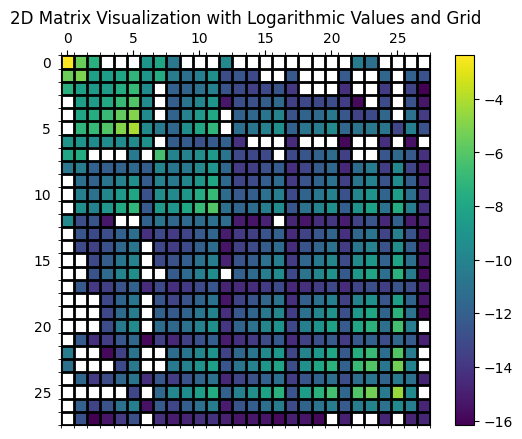

In [20]:
plot_matrix_with_log((COV_sim[6,:,:]))    #这里有问题，为什么取绝对值才相似，有些格子差负号

In [35]:
np.shape(data_vec)

(28, 49)

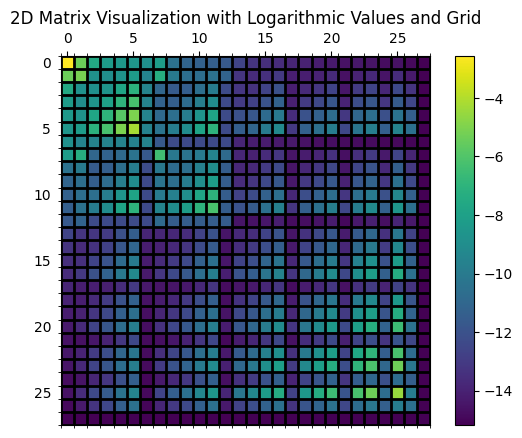

In [21]:
#Theoretical Cov matrix
plot_matrix_with_log(COV_th[6,:,:])

In [22]:
np.log(np.linalg.det(COV_th[3,:,:]))

-359.7937378908191

In [23]:
np.log(np.linalg.det(COV_sim[3,:,:]))

-355.3400455630917

In [38]:
import numpy as np

def is_positive_semidefinite(matrix):
    """检查矩阵是否为半正定"""
    eigenvalues = np.linalg.eigvalsh(matrix)
    return np.all(eigenvalues >= 0)


if is_positive_semidefinite(COV_sim[4,:,:]):
    print("协方差矩阵是半正定的")
else:
    print("协方差矩阵不是半正定的")


协方差矩阵是半正定的


In [142]:
for l in range(49):
    for i in range(28):
        for j in range(28):
            if i != j:
                COV_th[l,i,j] = 0

------------------------------ Choose one likelihood ----------------------------------

In [24]:
lcut=0

In [56]:
def gauss_cl_logp_single(r,AL,lmax=19, l_thres=0,  fsky=0.05563032882251974, lbin=50,dl_bias=None, correction=1):   #适用于一个field的情况
    """
    Defines a gaussian likelihood in log.
    """
    #r = np.random.randint(0,1)
    if correction == None:
        c = 0
    else : c=1
    likelihood_l = (2*l[lcut:lmax]+1)*fsky*lbin/2*(cl_data[lcut:lmax] - get_all_cheat(r,AL,dl_noise_temp,dl_bias,lmin=0,lmax=lmax)[lcut:lmax])**2/(cl_data[lcut:lmax])**2   #理论Covariance matrix
    #likelihood_l = (cl_data[lcut:lmax] - get_all_cheat(r,AL,dl_noise_temp,dl_bias,lmin=0,lmax=lmax)[lcut:lmax])**2/cov_de_de[lcut:lmax]  #模拟Covariance matrix
    #likelihood_l = (cl_data[lcut:] - get_all_cheat(r,dl_noise15)[lcut:])**2*(2*l[lcut:]+1)*fsky/4/(cl_data[lcut:])**2
    likelihood = -0.5*np.sum(likelihood_l)
    return likelihood

In [67]:
COV_INV = np.linalg.inv(COV_th)
COV_DET = np.log(np.linalg.det(COV_th))

In [25]:
COV_INV = np.linalg.inv(COV_sim)
COV_DET = np.log(np.linalg.det(COV_sim))

In [39]:
def gauss_cl_logp_th_cov(r, AL, A_d, A_s, alpha_d,  alpha_s,  beta_s, beta_d, dl_noise=dl_noise, nus=nus, eps_ds=0, bin=20, dl_bias=None, lmin=0, lbin_max = 5):
    """
    Defines a gaussian likelihood in log.
    """
    likelihood = 0
    X_theory = get_th_vec(r, AL, dl_noise, nus, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, dl_bias=None, lmin=0, lmax=100)
    for i in np.arange(lbin_max):
        likelihood_l = np.dot(np.dot((th_vec[:,i] - X_theory[:,i]).T, COV_INV[i,:,:] ), (th_vec[:,i] - X_theory[:,i])) + COV_DET[i]
        #likelihood_l = np.dot(np.dot((X_data[:,i] - X_theory[:,i]).T, cli(cal_cov_3(X_data,l[i],fsky=0.8,)[:,:,i])), (X_data[:,i] - X_theory[:,i])) 
        likelihood += -0.5*likelihood_l
    return likelihood

In [26]:
def gauss_cl_logp_sim_cov(r,AL,  A_d, A_s, alpha_d, alpha_s,  beta_s, beta_d, dl_noise=dl_noise_cheat, nus=nus, eps_ds=0, bin=20, dl_bias=None, lmin=0, lbin_max = 10):
    """
    Defines a gaussian likelihood in log.
    """
    likelihood = 0
    X_theory = get_th_vec(r, AL, dl_noise, nus, bin, A_d, A_s, alpha_s, alpha_d, beta_s, beta_d, eps_ds, dl_bias=None, lmin=0, lmax=200)
    for i in np.arange(1,lbin_max):
        likelihood_l = np.dot(np.dot((data_vec[:,i] - X_theory[:,i]).T, COV_INV[i,:,:] ), (data_vec[:,i] - X_theory[:,i])) + COV_DET[i]
        #likelihood_l = np.dot(np.dot((X_data[:,i] - X_theory[:,i]).T, cli(cal_cov_3(X_data,l[i],fsky=0.8,)[:,:,i])), (X_data[:,i] - X_theory[:,i])) 
        likelihood += -0.5*likelihood_l
    return likelihood

In [27]:
# Check the chi square value

a = gauss_cl_logp_sim_cov(0, 1, A_d0, A_s0, alpha_d0, alpha_s0,  beta_s0, beta_d0, dl_noise=dl_noise_cheat, nus=nus, eps_ds=0, bin=20, dl_bias=None, lmin=0, lbin_max = 10)
a

/tmp/ipykernel_17238/978265064.py:52: RuntimeWarning: divide by zero encountered in power
  Dl_d = A_d * (l/l0) ** alpha_d
/tmp/ipykernel_17238/978265064.py:53: RuntimeWarning: divide by zero encountered in power
  Dl_s = A_s * (l/l0) ** alpha_s
/tmp/ipykernel_17238/978265064.py:68: RuntimeWarning: divide by zero encountered in power
  Dl_d = A_d * (l/l0) ** alpha_d
/tmp/ipykernel_17238/978265064.py:69: RuntimeWarning: divide by zero encountered in power
  Dl_s = A_s * (l/l0) ** alpha_s
/tmp/ipykernel_17238/978265064.py:72: RuntimeWarning: invalid value encountered in multiply
  Dl_cross = eps_ds *(f_d1*f_s2*np.sqrt(Dl_d * Dl_s) + f_d2*f_s1*np.sqrt(Dl_d * Dl_s))


1467.2241552950923

In [ ]:
def gauss_cl_logp2(r,AL, lmax=19, l_thres=0, dl_bias=None,):
    """
    Defines a gaussian likelihood in log.
    """
    likelihood = 0
    X_theory = get_data_vector(r,AL,dl_noise_temp[:lmax],dl_bias,lmin=l_thres,lmax=lmax)
    for i in  range(0,lmax):       
        likelihood_l = (2*i+1)/2*np.trace(np.outer((X_data[:,i] - X_theory[:,i]), np.dot(np.diag(1 / X_theory[:,i]), np.dot((X_data[:,i] - X_theory[:,i]), np.diag(1 / X_theory[:,i]))))) + np.log(np.linalg.det(cal_cov_3(X_theory,i,fsky=0.8,)[:,:,i]))
        likelihood += -0.5*likelihood_l
    return likelihood

In [11]:
mask = hp.read_map('/root/Testarea/prototype/A_PARTIAL_SKY/A_IN_USING/mask2048_cut_sm.fits')
mask = hp.read_map('/root/Testarea/prototype/A_PARTIAL_SKY/A_IN_USING/PLANCK_2048_sm-cut-mask.fits')
f = calc_fsky(2048,mask,mask)
f

0.3157246510563356

---------------------------------- Here we go ----------------------------------------

In [28]:
info = {"likelihood": {"r&AL": gauss_cl_logp_sim_cov}}

In [29]:
info["params"] = {
    "r": {"prior": {"min": -0.1, "max": 0.1}, "ref": 0, "proposal": 0.001, "latex": r"r"},
    "AL": {"prior": {"min": 0.8, "max": 2.2}, "ref": 1, "proposal": 0.001, "latex": r"A_L"},
    "A_d": {"prior": {"min": 10, "max": 16}, "ref": 14.30, "proposal": 0.05, "latex": r"A_d"},
    "alpha_d": {"prior": {"min": -0.9, "max": -0.3}, "ref": -0.65, "proposal": 0.005, "latex": r"\alpha_d"},
    "beta_d": {"prior": {"min": 1.3, "max": 1.8}, "ref": 1.48, "proposal": 0.001, "latex": r"\beta_d"},
    "A_s": {"prior": {"min": 1, "max": 4}, "ref": 2.40, "proposal": 0.005, "latex": r"A_s"},
    "alpha_s": {"prior": {"min": -1.4, "max": 0}, "ref": -0.80, "proposal": 0.003, "latex": r"\alpha_s"},
    "beta_s": {"prior": {"min": -3.3, "max": -2.7}, "ref": -3.1, "proposal": 0.001, "latex": r"\beta_s"},
}

In [47]:
#info["output"] = "/root/Testarea/prototype/Foreground/post_cal4/cobaya_output"  # 指定输出文件夹
#info["force"] = True
#info["resume"] = False
#info["debug"] = True  # 开启调试模式         

In [30]:
import warnings

# 过滤掉RuntimeWarning类型的警告
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [31]:
info["sampler"] = {"mcmc": {"Rminus1_stop": 1e-3, 
                            "max_tries": 1000000000, 
                            #"covmat_params": ["r","AL","A_d","alpha_d","beta_d","A_s","alpha_s","beta_s"],
                            #"covmat": [[0.001,0,0,0,0,0,0,0], [0,0.01,0,0,0,0,0,0], [0,0,0.3,0.1,0.1,0.01,0.01,0.01], [0,0,0.1,0.3,0.1,0.01,0.01,0.01], 
                                       #[0,0,0.1,0.1,0.3,0.01,0.01,0.01], [0,0,0.01,0.01,0.01,0.3,0.1,0.1], [0,0,0.01,0.01,0.01,0.1,0.3,0.1], [0,0,0.01,0.01,0.01,0.1,0.1,0.3]],}
                            #"covmat_params": ["r","AL",],
                            #"covmat": [[0.001,0.0003],[0.0003,0.002]],}
}}

from cobaya import run
updated_info, sampler = run(info)

[r&al] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: r:0, AL:1, A_d:14.3, alpha_d:-0.65, beta_d:1.48, A_s:2.4, alpha_s:-0.8, beta_s:-3.1
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {r&AL: 71.8}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-26 08:00:42 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.553
[mcmc]  - Convergence of means: R-1 = 25.767417 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 640 samples accepted.
[mcmc]  - Acceptance rate: 0.627
[mcmc]  - Convergence of means: R-1 = 5.768870 after 512 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + c

KeyboardInterrupt: 

In [45]:
# Export the results to GetDist
gd_sample = sampler.products(to_getdist=True)["sample"]

# Analyze and plot
mean = gd_sample.getMeans()[:8]
covmat = gd_sample.getCovMat().matrix[:8, :8]
print("Mean:")
print(mean)
print("Standard error:")
print(np.sqrt(covmat))
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["r","AL","A_d","alpha_d","beta_d","A_s","alpha_s","beta_s"], filled=True, contour_colors=['red'])  #"r","AL","A_d","alpha_d","beta_d","A_s","alpha_s","beta_s"


for i in range(8):
    gdplot.subplots[i, i].axvline(x=mean[i], color='r', linestyle=':')
    gdplot.subplots[i, i].text(mean[i], 1, f"Mean: {mean[i]:.6f}", fontsize=6, color='green', ha='left', va='top')
    gdplot.subplots[i, i].text(mean[i], 0.9, f"Sigma: {np.sqrt(covmat[i])[i]:.6f}", fontsize=6, color='green', ha='left', va='top')
    #gdplot.subplots[i, i].set_xlim(0, 5)

gdplot.add_text("lens_sim, cov_sim, lens=1, nosqrtAL ", x=0, y=3)

gdplot.export('gaussian2.png',dpi=300)

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
Mean:
[-1.81552199e-06  9.97389361e-01  1.42287651e+01 -6.43975725e-01
  1.48027849e+00  2.38492012e+00 -7.79058763e-01 -3.10006848e+00]
Standard error:
[[9.24166149e-04            nan 6.60593023e-03            nan
  4.48056052e-04 1.78996586e-03            nan            nan]
 [           nan 3.91351994e-02            nan 1.14802481e-02
  4.38358718e-03            nan            nan            nan]
 [6.60593023e-03            nan 6.10668524e-01            nan
  1.97816613e-02 1.29076341e-02            nan            nan]
 [           nan 1.14802481e-02            nan 6.91741638e-02
  3.96184389e-03            nan            nan 8.86107659e-03]
 [4.48056052e-04 4.38358718e-03 1.97816613e-02 3.96184389e-03
  8.14450340e-03            nan            nan 4.70388583e-03]
 [1.78996586e-03            nan 1.29076341e-02            nan
             nan 1.61316890e-01 6.55782766e-0